In [1]:
import os
os.chdir('../..')
!ls

product_impacts


python(10356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
import os.path
import pandas as pd
from skimpy import skim
import requests
from bs4 import BeautifulSoup
import statistics
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerLevel

from product_impacts.product_cat.run_model import get_store, get_ndns_cats, get_products, get_ndns_matches, get_tsne

import numpy as np
import pickle
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

python(10393) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ["RAY_ENABLE_MAC_LARGE_OBJECT_STORE"] = "1"

In [5]:
ndns = get_ndns_cats('../../SFS/NDNS UK/ndns_edited.csv')
products = get_products()
labelled_data, non_food_products = get_ndns_matches(
    ndns, products)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# removing duplicated product names + ingredients (basically products with same exact feature vectors)
labelled_data['product_list_name_lower'] = labelled_data['product_list_name'].str.lower()
labelled_data['ingredients_text_lower'] = labelled_data['ingredients_text'].str.lower()
labelled_data = labelled_data.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [7]:
# lev 0 predictions
predicted_data = pd.read_csv('../../SFS/NDNS UK/predictions/predictions_lev0_manuallabels_nonHI_RF_withcorrections_14Oct2024.csv')

In [8]:
predicted_data.shape

(262711, 11)

In [9]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             52426
Miscellaneous                           27598
Meat and Meat Products                  26837
Non-Alcoholic Beverages                 25994
Sugar, Preserves and Confectionery      25822
Vegetables, Potatoes                    23757
Milk and Milk Products                  23239
Alcoholic Beverages                     15150
Fish and Fish Dishes                     9302
Fruit                                    7343
Savoury Snacks                           6460
Not Food                                 5086
Nuts and Seeds                           5057
Fat Spreads                              3811
Commercial Toddlers Foods and Drinks     2488
Eggs and Egg Dishes                      1315
Dietary Supplements                       622
Artificial Sweeteners                     404
Name: parentcategory_pred, dtype: int64

In [10]:
pred = predicted_data[predicted_data['parentcategory_pred']=='Fruit'].reset_index(drop=True)
lab = labelled_data[(labelled_data['parentcategory']=='Fruit')
                           & (labelled_data['subfoodgroupdesc'].notnull())].reset_index(drop=True)
lab = lab.merge(pred[['product_id']])

In [11]:
pred.shape

(7343, 11)

In [12]:
lab.shape

(1342, 12)

In [13]:
lab['subfoodgroupdesc'].value_counts()

Other fruit not canned         718
Apples and pears not canned    236
Citrus fruit not canned        132
Canned fruit in juice          129
Canned fruit in syrup           85
Bananas                         42
Name: subfoodgroupdesc, dtype: int64

In [14]:
lab['mainfoodgroupdesc'].value_counts()

Fruit    1342
Name: mainfoodgroupdesc, dtype: int64

In [15]:
pred['subfoodgroup_lab'].value_counts()

Other fruit not canned                         718
Apples and pears not canned                    236
Citrus fruit not canned                        132
Canned fruit in juice                          129
Canned fruit in syrup                           84
Bananas                                         42
Nuts and seeds                                  19
Soft drinks not low calorie concentrated         7
Fruit juice                                      6
Sugar confectionery                              4
Other vegetable products and dishes              3
Tomatoes                                         3
Crisps and savoury snacks                        2
Fruit pies                                       2
Fromage frais and other dairy desserts           1
Other cereal based puddings                      1
Non-nutrient supplements (including herbal)      1
Ice cream                                        1
Buns cakes and pastries                          1
Preserves                      

In [16]:
# correcting some labels

lab.loc[(lab['subfoodgroupdesc']=='Canned fruit in syrup')
         & (lab['product_list_name'].str.lower().str.contains('juice')),
        'subfoodgroupdesc'] = 'Canned fruit in juice'

lab.loc[(lab['subfoodgroupdesc']=='Citrus fruit not canned')
         & (lab['product_list_name'].str.lower().str.contains('juice')),
        'subfoodgroupdesc'] = 'Canned fruit in juice'

lab.loc[(lab['subfoodgroupdesc']=='Canned fruit in syrup')
         & (lab['product_list_name'].str.lower().str.contains(' apple ')),
        'subfoodgroupdesc'] = 'Apples and pears not canned'

In [17]:
# correcting the lev 1 categories and codes
lab = lab.drop(['mainfoodgroupcode', 'mainfoodgroupdesc', 'subfoodgroupcode'], axis=1)
lab = lab.merge(
    ndns[['mainfoodgroupcode', 'mainfoodgroupdesc', 'subfoodgroupcode', 'subfoodgroupdesc']].drop_duplicates(
        subset=['subfoodgroupdesc']), how='left')

In [18]:
lab['subfoodgroupdesc'].value_counts()

Other fruit not canned         718
Apples and pears not canned    240
Canned fruit in juice          160
Citrus fruit not canned        112
Canned fruit in syrup           70
Bananas                         42
Name: subfoodgroupdesc, dtype: int64

In [19]:
lab['mainfoodgroupdesc'].value_counts()

Fruit    1342
Name: mainfoodgroupdesc, dtype: int64

In [20]:
lev2_labels_add = pred[[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store']]
lev2_labels_add['parentcategory'] = 'Fruit'
lev2_labels_add['subfoodgroupdesc'] = np.NaN

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mandarin"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("juice")),
                    'subfoodgroupdesc'] = 'Canned fruit in juice'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("peach halves"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("juice")),
                    'subfoodgroupdesc'] = 'Canned fruit in juice'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mango pulp")),
                    'subfoodgroupdesc'] = 'Canned fruit in juice'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mango"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("juice")),
                    'subfoodgroupdesc'] = 'Canned fruit in juice'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("princes"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("juice")),
                    'subfoodgroupdesc'] = 'Canned fruit in juice'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pineapple"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("syrup")),
                    'subfoodgroupdesc'] = 'Canned fruit in syrup'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("raspberries"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("syrup")),
                    'subfoodgroupdesc'] = 'Canned fruit in syrup'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mandarins"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("syrup")),
                    'subfoodgroupdesc'] = 'Canned fruit in syrup'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("rhubarb"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("syrup")),
                    'subfoodgroupdesc'] = 'Canned fruit in syrup'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("apple sauce")),
                    'subfoodgroupdesc'] = 'Apples and pears not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("biona"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains(" apple")),
                    'subfoodgroupdesc'] = 'Apples and pears not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("biona"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("pear")),
                    'subfoodgroupdesc'] = 'Apples and pears not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("clearspring"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains(" apple")),
                    'subfoodgroupdesc'] = 'Apples and pears not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("raspberries"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("syrup"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("juice")),
                    'subfoodgroupdesc'] = 'Other fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("peaches"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("syrup"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("juice")),
                    'subfoodgroupdesc'] = 'Other fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("olives chilli")),
                    'subfoodgroupdesc'] = 'Other fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mixed berry pot")),
                    'subfoodgroupdesc'] = 'Other fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mango pot")),
                    'subfoodgroupdesc'] = 'Other fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mango, melon")),
                    'subfoodgroupdesc'] = 'Other fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mango chunks")),
                    'subfoodgroupdesc'] = 'Other fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("rhubarb"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("syrup")),
                    'subfoodgroupdesc'] = 'Other fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fruit bowl"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("peeler")),
                    'subfoodgroupdesc'] = 'Other fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mandarins"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("syrup"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("juice")),
                    'subfoodgroupdesc'] = 'Citrus fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("orange"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("river"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("melon"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("sultana"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("syrup"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("juice")),
                    'subfoodgroupdesc'] = 'Citrus fruit not canned'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("st limes")),
                    'subfoodgroupdesc'] = 'Citrus fruit not canned'

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A val

In [21]:
# lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("st limes"))
#                    ]

In [22]:
lev2_labels_add = lev2_labels_add.merge(
    ndns.drop('detaileddesc', axis=1)).drop_duplicates(subset=['product_id', 'subfoodgroupdesc'])
lev2_labels_add['product_list_name_lower'] = lev2_labels_add['product_list_name'].str.lower()
lev2_labels_add['ingredients_text_lower'] = lev2_labels_add['ingredients_text'].str.lower()
lev2_labels_add = lev2_labels_add.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

dups = lab[['product_id', 'product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']].merge(
    lev2_labels_add[['product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']])['product_id'].values
lev2_labels_add = lev2_labels_add[(~lev2_labels_add['product_id'].isin(dups))]
lab = lab[(~lab['product_id'].isin(lev2_labels_add['product_id'].values))]
lab = pd.concat([lab, lev2_labels_add], ignore_index=True, axis=0).drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [23]:
lab.shape

(1572, 12)

In [24]:
lab['subfoodgroupdesc'].value_counts()

Other fruit not canned         825
Apples and pears not canned    289
Canned fruit in juice          210
Citrus fruit not canned        132
Canned fruit in syrup           74
Bananas                         42
Name: subfoodgroupdesc, dtype: int64

In [25]:
pred = pred.drop('mainfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'mainfoodgroupdesc']], how='left').rename(columns={'mainfoodgroupdesc': 'mainfoodgroup_lab'})

pred = pred.drop('subfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'subfoodgroupdesc']], how='left').rename(columns={'subfoodgroupdesc': 'subfoodgroup_lab'})

In [26]:
query_embeddings = np.load('../../SFS/bert/all_embeddings_all3.npy')
tsne_results = get_tsne(query_embeddings, '../../SFS/bert/tsne_results_all3.npy')
product_ids = np.load('../../SFS/bert/all_ids_all3.npy')

features = pd.DataFrame(data=query_embeddings)
id_col = 'product_id'
X_cols = features.columns.tolist()
y_cols = ['parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']

features['product_id'] = pd.Series(product_ids, index=features.index)
features[['tsne_0', 'tsne_1']] = tsne_results
lab = lab.merge(features)

In [27]:
acc_list_train = []
bal_acc_list_train = []
precision_list_train = []
recall_list_train = []
f1_list_train = []
mcc_list_train = []

acc_list_test = []
bal_acc_list_test = []
precision_list_test = []
recall_list_test = []
f1_list_test = []
mcc_list_test = []

for i in range(1):
    train, test = train_test_split(lab, test_size=0.2, random_state=i)
    print(f'Number of unique level 1 categories in train: {train[y_cols[1]].nunique()}')
    print(f'Number of unique level 1 categories in test: {test[y_cols[1]].nunique()}')
    print(f'Number of unique level 2 categories in train: {train[y_cols[2]].nunique()}')
    print(f'Number of unique level 2 categories in test: {test[y_cols[2]].nunique()}\n')

    X_train = train[X_cols]
    y_train = train[[y_cols[1], y_cols[2]]]
    y_train1 = train[y_cols[1]]
    y_train2 = train[y_cols[2]]

    X_test = test[X_cols]
    y_test = test[[y_cols[1], y_cols[2]]]
    y_test1 = test[y_cols[1]]
    y_test2 = test[y_cols[2]]

    mod = RandomForestClassifier(n_estimators=400, 
                                 min_samples_leaf=10, 
                                 max_depth=25,
                                 class_weight='balanced'
                                )

    clf2 = mod
    clf2.fit(X_train, y_train2)
    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)

    y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
    y_test_pred1 = pd.DataFrame(y_test_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values

    print(f'Lev 1 train accuracy: {accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 train balanced accuracy: {balanced_accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 test accuracy: {accuracy_score(y_test1, y_test_pred1)}')
    print(f'Lev 1 test balanced accuracy: {balanced_accuracy_score(y_test1, y_test_pred1)}\n')

    print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 test accuracy: {accuracy_score(y_test2, y_test_pred2)}')
    print(f'Lev 2 test balanced accuracy: {balanced_accuracy_score(y_test2, y_test_pred2)}\n')

    print(f'Number of unique level 1 categories predicted in train: {len(np.unique(y_train_pred1))}')
    print(f'Number of unique level 1 categories predicted in test: {len(np.unique(y_test_pred1))}')    
    print(f'Number of unique level 2 categories predicted in train: {len(np.unique(y_train_pred2))}')
    print(f'Number of unique level 2 categories predicted in test: {len(np.unique(y_test_pred2))}\n')    
    
    acc_list_train.append(accuracy_score(y_train2, y_train_pred2))
    bal_acc_list_train.append(balanced_accuracy_score(y_train2, y_train_pred2))
    precision_list_train.append(precision_score(y_train2, y_train_pred2, average='weighted'))
    recall_list_train.append(recall_score(y_train2, y_train_pred2, average='weighted'))
    f1_list_train.append(f1_score(y_train2, y_train_pred2, average='weighted'))
    mcc_list_train.append(matthews_corrcoef(y_train2, y_train_pred2))
    
    acc_list_test.append(accuracy_score(y_test2, y_test_pred2))
    bal_acc_list_test.append(balanced_accuracy_score(y_test2, y_test_pred2))
    precision_list_test.append(precision_score(y_test2, y_test_pred2, average='weighted'))
    recall_list_test.append(recall_score(y_test2, y_test_pred2, average='weighted'))
    f1_list_test.append(f1_score(y_test2, y_test_pred2, average='weighted'))
    mcc_list_test.append(matthews_corrcoef(y_test2, y_test_pred2))

Number of unique level 1 categories in train: 1
Number of unique level 1 categories in test: 1
Number of unique level 2 categories in train: 6
Number of unique level 2 categories in test: 6

Lev 1 train accuracy: 1.0
Lev 1 train balanced accuracy: 1.0
Lev 1 test accuracy: 1.0
Lev 1 test balanced accuracy: 1.0

Lev 2 train accuracy: 0.9856801909307876
Lev 2 train balanced accuracy: 0.9868136262896142
Lev 2 test accuracy: 0.9523809523809523
Lev 2 test balanced accuracy: 0.9325263504475036

Number of unique level 1 categories predicted in train: 1
Number of unique level 1 categories predicted in test: 1
Number of unique level 2 categories predicted in train: 6
Number of unique level 2 categories predicted in test: 6



In [28]:
print('train')
print(f'accuracy: {statistics.mean(acc_list_train)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_train)}')
print(f'precision: {statistics.mean(precision_list_train)}')
print(f'recall: {statistics.mean(recall_list_train)}')
print(f'f1: {statistics.mean(f1_list_train)}')
print(f'mcc: {statistics.mean(mcc_list_train)}')

print('test')
print(f'accuracy: {statistics.mean(acc_list_test)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_test)}')
print(f'precision: {statistics.mean(precision_list_test)}')
print(f'recall: {statistics.mean(recall_list_test)}')
print(f'f1: {statistics.mean(f1_list_test)}')
print(f'mcc: {statistics.mean(mcc_list_test)}')

train
accuracy: 0.9856801909307876
balanced accuracy: 0.9868136262896142
precision: 0.9861444553885849
recall: 0.9856801909307876
f1: 0.9858019631570013
mcc: 0.9785047322676289
test
accuracy: 0.9523809523809523
balanced accuracy: 0.9325263504475036
precision: 0.9533454036222585
recall: 0.9523809523809523
f1: 0.9518387729363335
mcc: 0.9283272250564831


In [28]:
X_train = lab[X_cols]
y_train = lab[[y_cols[1], y_cols[2]]]
y_train1 = lab[y_cols[1]]
y_train2 = lab[y_cols[2]]

pred = pred.drop(['tsne_0', 'tsne_1'], axis=1).merge(features)
X_pred = pred[X_cols]

mod = RandomForestClassifier(n_estimators=500, 
                             min_samples_leaf=10, 
                             max_depth=20,
                             class_weight='balanced'
                            )

clf2 = mod
clf2.fit(X_train, y_train2)
y_train_pred2 = clf2.predict(X_train)
y_pred2 = clf2.predict(X_pred)

y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
y_pred1 = pd.DataFrame(y_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values


print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')

print(f'Number of unique level 2 categories in train: {len(np.unique(y_train_pred2))}')
print(f'Number of unique level 2 categories in pred: {len(np.unique(y_pred2))}')    

pred['mainfoodgroup_pred'] = pd.Series(y_pred1, index = pred.index)
pred['subfoodgroup_pred'] = pd.Series(y_pred2, index = pred.index)

cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'mainfoodgroup_pred', 'subfoodgroup_pred', 'tsne_0', 'tsne_1']

pred = pred[cols]

print(pred[(pred['subfoodgroup_lab'].notnull()) & (pred['parentcategory_lab']==pred['parentcategory_pred'])
           & (pred['subfoodgroup_lab']!=pred['subfoodgroup_pred'])].shape)

Lev 2 train accuracy: 0.9872773536895675
Lev 2 train balanced accuracy: 0.9882032918192087
Number of unique level 2 categories in train: 6
Number of unique level 2 categories in pred: 6
(18, 13)


In [29]:
pred['subfoodgroup_pred'].value_counts()

Other fruit not canned         5177
Canned fruit in juice           782
Apples and pears not canned     747
Citrus fruit not canned         292
Canned fruit in syrup           227
Bananas                         118
Name: subfoodgroup_pred, dtype: int64

In [30]:
# 

In [ ]:
pred.sample(100)[['product_list_name', 'ingredients_text', 'subfoodgroup_lab', 'subfoodgroup_pred']].sort_values(
    by='subfoodgroup_pred').reset_index(drop=True)

In [32]:
# pred[pred['subfoodgroup_pred']=='Other fruit not canned'].sample(100).sort_values(by='product_list_name').reset_index(drop=True)

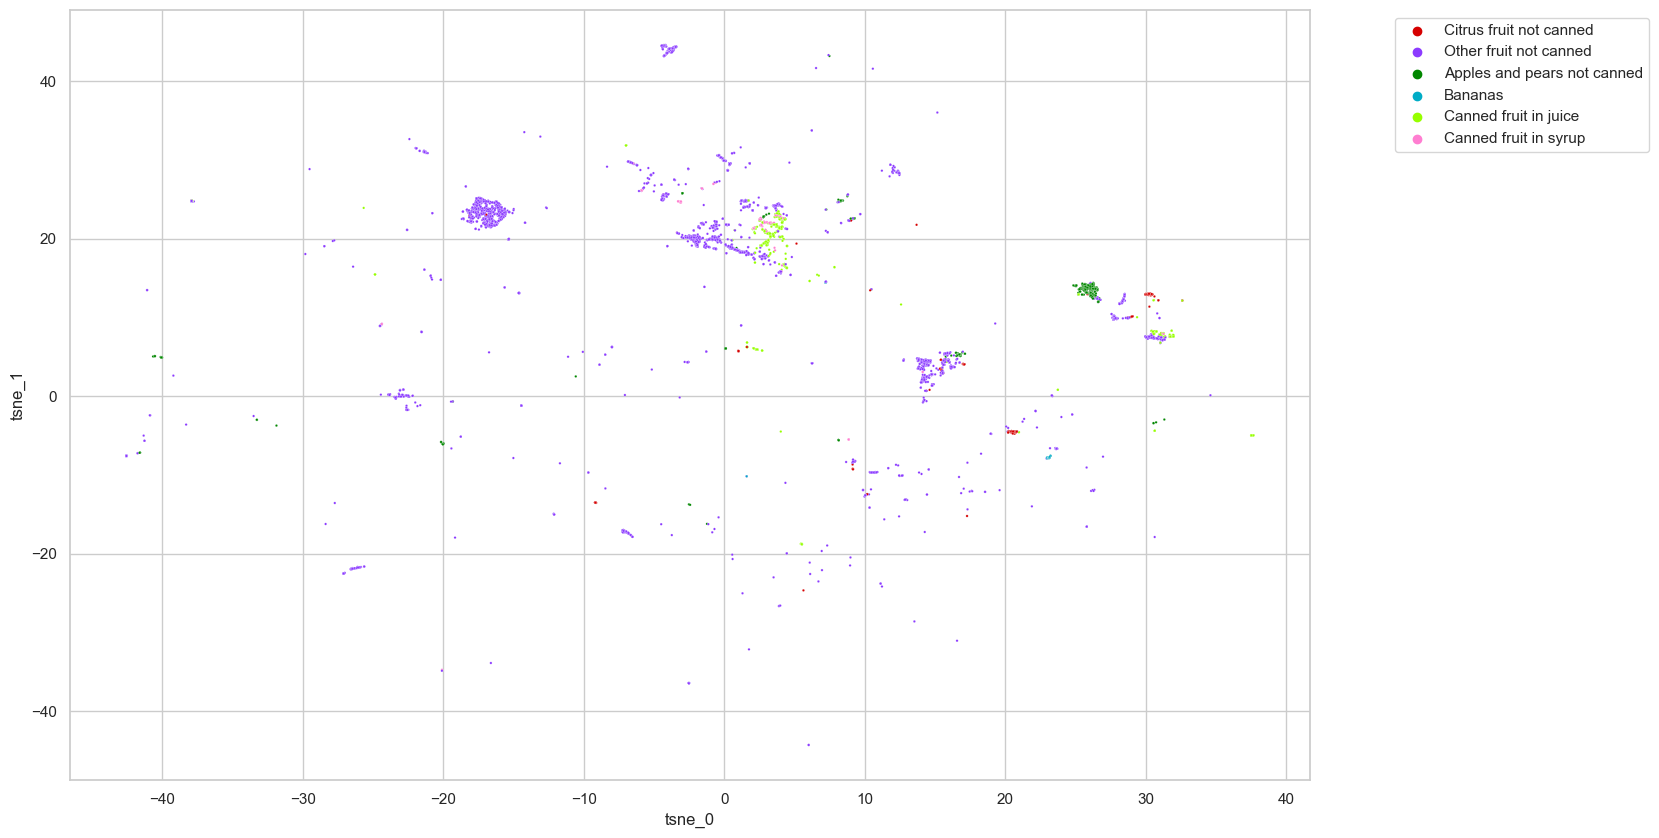

In [33]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pred['tsne_0'], y=pred['tsne_1'],
    hue=pred['subfoodgroup_pred'],
    palette=sns.color_palette(cc.glasbey, n_colors=pred['subfoodgroup_pred'].nunique()), s=3
)
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right')

In [34]:
# save level 2 cereal categories
pred.to_csv('../../SFS/NDNS UK/predictions/predictions_fruit_lev2_manuallabels_nonHI_RF_15Oct2024.csv', 
                      index=False)